<a href="https://colab.research.google.com/github/wilbertosmond/gnn-eatingdisorder/blob/main/GNN%2BLSTM_(gVAR36).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Import Libraries**

In [ ]:
pip install dgl

     |████████████████████████████████| 4.4MB 2.9MB/s 


In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold

import torch as th
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
import matplotlib.pyplot as plt

import dgl
from dgl.nn.pytorch import GraphConv, SAGEConv, GATConv, GatedGraphConv

import warnings
warnings.filterwarnings('ignore')

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## **1. Load and Preprocess Data**

In [ ]:
# load data
df=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/df_36items_cleaned_withNA.xlsx")

# Filter out ID's with NA<10% and group ID into array
df.set_index('ID', inplace=True)
ID_list = df.index.unique()
df_individuals = []
for ID in ID_list:
  df_individual = df[df.index==ID]
  df_individual = df_individual.fillna(df_individual.mean()) # impute mean of each individual for NaN
  df_individuals.append(df_individual)
print(len(df_individuals))

df_individuals[0].head()

47


day  beepvar  dh10  dh11  dh12  dh13  ...  dh51  dh52  dh53  dh54  dh58  dh61
ID                                         ...                                    
002    1        1   2.0   2.0   2.0   3.0  ...   3.0   2.0   1.0   3.0   2.0   2.0
002    1        2   2.0   2.0   5.0   3.0  ...   2.0   3.0   2.0   4.0   2.0   4.0
002    1        3   4.0   3.0   3.0   4.0  ...   3.0   3.0   3.0   5.0   4.0   3.0
002    1        4   4.0   3.0   2.0   2.0  ...   2.0   2.0   2.0   4.0   2.0   3.0
002    2        1   4.0   4.0   3.0   4.0  ...   3.0   3.0   2.0   5.0   4.0   3.0

[5 rows x 38 columns]

In [ ]:
def preprocess_data(df_individual):
    X = df_individual.iloc[:,2:].values
    X = np.array(X)
    
    # Split data into 80% train, 20% test
    train, test = train_test_split(X, test_size=0.2, shuffle=False) # need to split not randomly
    
    # Normalize train and test
    sc = Normalizer(norm = 'max').fit(train)
    train = sc.transform(train)
    test = sc.transform(test)
    
    return train, test

train, test = preprocess_data(df_individuals[0])
print(train.shape, test.shape)
print(train[0]) # 36 items for first timepoint

(57, 36) (15, 36)
[0.5  0.5  0.5  0.75 0.5  0.5  1.   1.   0.5  0.5  1.   0.25 0.75 0.5
 0.25 0.5  0.25 0.25 0.25 0.5  0.25 0.25 0.25 0.25 0.25 1.   0.75 0.25
 0.25 0.75 0.75 0.5  0.25 0.75 0.5  0.5 ]


In [ ]:
def create_inout_sequences(input_data, time_window):
    x, y = [], []
    L = len(input_data)
    for i in range(L-time_window):
        train_seq = input_data[i:i+time_window]
        train_label = input_data[i+time_window]
        x.append(train_seq)
        y.append(train_label)
    return th.FloatTensor(x), th.FloatTensor(y)

x_train, y_train = create_inout_sequences(train, 3)
x_test, y_test = create_inout_sequences(test, 3)

print(x_train.shape, y_train.shape) # for train data: 54 timepoints, lag-3, 36 items
print(x_test.shape, y_test.shape)
print(x_train[0]) # lag-3 of 36 items

torch.Size([54, 3, 36]) torch.Size([54, 36])
torch.Size([12, 3, 36]) torch.Size([12, 36])
tensor([[0.5000, 0.5000, 0.5000, 0.7500, 0.5000, 0.5000, 1.0000, 1.0000, 0.5000,
         0.5000, 1.0000, 0.2500, 0.7500, 0.5000, 0.2500, 0.5000, 0.2500, 0.2500,
         0.2500, 0.5000, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 1.0000, 0.7500,
         0.2500, 0.2500, 0.7500, 0.7500, 0.5000, 0.2500, 0.7500, 0.5000, 0.5000],
        [0.3333, 0.3333, 0.8333, 0.5000, 0.3333, 0.5000, 0.5000, 0.5000, 0.3333,
         0.1667, 0.5000, 0.3333, 0.5000, 0.1667, 0.3333, 0.3333, 0.3333, 0.5000,
         0.6667, 0.3333, 0.3333, 0.5000, 0.3333, 0.3333, 0.1667, 0.3333, 1.0000,
         0.3333, 0.3333, 0.5000, 0.3333, 0.5000, 0.3333, 0.6667, 0.3333, 0.6667],
        [0.8000, 0.6000, 0.6000, 0.8000, 0.8000, 0.6116, 1.0000, 0.8000, 0.4000,
         0.4000, 0.6000, 0.4000, 0.8000, 0.6000, 0.4000, 0.4000, 0.4000, 1.0000,
         1.0000, 0.6000, 1.0000, 0.8000, 0.6000, 0.4000, 0.4000, 0.4000, 0.8000,
         0.2000, 

## **2. Initialize Model**

In [ ]:
gvar36=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/gvar36 (gamma=0.5).xlsx", index_col=0)
gvar36.head()

dh10  dh11      dh12     dh13      dh14  ...      dh52  dh53  dh54  dh58  dh61
dh10     0   0.0  0.000000  0.00000  0.000000  ...  0.000000   0.0   0.0   0.0   0.0
dh11     0   0.0  0.000000  0.00000  0.000000  ...  0.000000   0.0   0.0   0.0   0.0
dh12     0   0.0  0.049013  0.00000  0.000000  ...  0.000000   0.0   0.0   0.0   0.0
dh13     0   0.0  0.016180  0.03802  0.000000  ...  0.000000   0.0   0.0   0.0   0.0
dh14     0   0.0  0.000000  0.00000  0.013924  ...  0.011953   0.0   0.0   0.0   0.0

[5 rows x 36 columns]

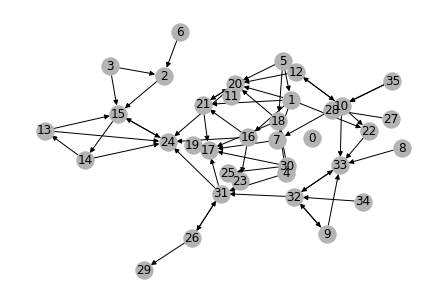

In [52]:
# Construct Graph
def ED_graph(adj_mtrx):
  # Initialize edges (node source and node destination)
  src = np.nonzero(adj_mtrx.values)[0] # source endpoints
  dst = np.nonzero(adj_mtrx.values)[1] # destination endpoints
  edges = th.tensor(src), th.tensor(dst)
  g = dgl.graph(edges)

  # Initialize weights of edges
  #weights = []
  #for i in range(len(edges[0])):
  #  weights.append(adj_mtrx.values[src[i], dst[i]])
  #g.edata['w'] = th.tensor(weights)
    
  # Construct a DGL Graph
  return g
G = ED_graph(gvar36)

nx_G = G.to_networkx()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])
plt.show()

In [ ]:
# Define GraphSAGE model that contains two GraphSAGE layers
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, aggregator):
        super(GraphSAGE, self).__init__()
        self.sage1 = SAGEConv(in_feats, hidden_size, aggregator)
        self.sage2 = SAGEConv(hidden_size, num_classes, aggregator)

    def forward(self, g, inputs):
        x = F.relu(self.sage1(g, inputs))
        x = self.sage2(g, x)
        return x

In [ ]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,time_window,n_layers):
        super(LSTM, self).__init__()
        self.n_nodes = input_size
        self.time_window = time_window
        self.n_hidden = hidden_size
        self.n_layers = n_layers 
    
        self.lstm = nn.LSTM(input_size = n_nodes, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.fc = nn.Linear(self.n_hidden*self.time_window, n_nodes)
        
    
    def init_hidden(self, batch_size):
        h_0 = th.zeros(self.n_layers,batch_size,self.n_hidden)
        c_0 = th.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (h_0, c_0)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        lstm_out, self.hidden = self.lstm(x,self.hidden)
        
        x = lstm_out.contiguous().view(1, -1) # first index supposed to be batch_size
        x = self.fc(x)
        
        return x

In [ ]:
# Combine GNN with LSTM
class GNN_LSTM(nn.Module):
  def __init__(self, n_nodes, n_features):
    super(GNN_LSTM, self).__init__()
    self.n_nodes = n_nodes
    self.n_features = n_features

    self.gnn = GraphSAGE(self.n_features, 5, self.n_features, 'lstm') # 5 n_hidden for GNN layer
    self.lstm = LSTM(self.n_nodes, 20, self.n_features, 1) # 20 n_hidden for LSTM layer, 1 LSTM layer

  def forward(self, g, inputs):
    #print("GNN input:", inputs.shape) #print for debugging and checking I/O shapes
    y_pred_GNN = self.gnn(g, inputs) # input features of GNN are the previous n timepoints
    #print("GNN output:", y_pred_GNN.shape)
    self.lstm.init_hidden(1)
    #print("LSTM input:", y_pred_GNN.view(1, self.n_features, self.n_nodes, ).shape)
    y_pred_LSTM = self.lstm(y_pred_GNN.view(1, self.n_features, self.n_nodes, )) # 1 = batch_size
    #print("LSTM output:", y_pred_LSTM.shape)

    return y_pred_LSTM

## **3. Training & Testing**

### **3a. Patient 2**

In [ ]:
n_nodes = 36 # number of nodes in graph
n_features = 3 # number of parallel inputs (i.e. features) = timesteps

# initialize data for patient 2
train, test = preprocess_data(df_individuals[0]) #patient 2, output is np.array

# batch of time-series input features (for LSTM)
x_train, y_train = create_inout_sequences(train, n_features) #output is th.tensor
x_test, y_test = create_inout_sequences(test, n_features)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([54, 3, 36]) torch.Size([54, 36])
torch.Size([12, 3, 36]) torch.Size([12, 36])


In [ ]:
# split train data to train-val data using 10-fold cross-validation
def crossval(x_train, y_train, cv_type, n_fold):
  if cv_type == 'kfold': # randomly shuffled
    cv = KFold(n_splits=n_fold, shuffle=True)
  if cv_type == 'tscv': # for time-series, so time-ordered instead of randomly shuffled
    cv = TimeSeriesSplit(max_train_size=None, n_splits=n_fold)
  
  x_train_cv, x_val_cv, y_train_cv, y_val_cv = [], [], [], []
  for train_index, val_index in cv.split(x_train, y_train):
    #print("TRAIN:", train_index, "VAL:", val_index)
    cv_x_train, cv_x_val = x_train[train_index], x_train[val_index]
    cv_y_train, cv_y_val = y_train[train_index], y_train[val_index]
    x_train_cv.append(cv_x_train), x_val_cv.append(cv_x_val), y_train_cv.append(cv_y_train), y_val_cv.append(cv_y_val)
  return x_train_cv, y_train_cv, x_val_cv, y_val_cv

x_train_cv, y_train_cv, x_val_cv, y_val_cv = crossval(x_train, y_train, 'kfold', 5) #
print(len(x_train_cv), len(y_train_cv), len(x_val_cv), len(y_val_cv)) # tensors in a list
print(x_train_cv[0].shape, y_train_cv[0].shape, x_val_cv[0].shape, y_val_cv[0].shape)

5 5 5 5
torch.Size([43, 3, 36]) torch.Size([43, 36]) torch.Size([11, 3, 36]) torch.Size([11, 36])


In [ ]:
# GNN-LSTM train (SGD over n timesteps)
def model_init(lr=0.0005):
  th.manual_seed(42)
  model = GNN_LSTM(n_nodes, n_features)
  optimizer = th.optim.Adam(model.parameters(), lr=lr)
  return model, optimizer

def model_train_val(model, x_train, y_train, x_val, y_val, optimizer, epochs=25):
  model.train()

  y_pred_train = []
  y_pred_val = []
  loss_train = []
  loss_val = []

  for epoch in range(epochs):
      epoch_val_loss = []
      epoch_train_loss = []
      for t in range(len(x_train)-1):
          ### train model ---------------
          y_train_pred = model(G, x_train[t].T) # transpose input shape from (n_features,n_nodes) to (n_nodes,n_features)
          train_loss = F.mse_loss(y_train_pred, y_train[t]) # LSTM instead of mean
          
          optimizer.zero_grad() # clear previous gradients
          train_loss.backward() # backpropagation
          optimizer.step()
          
          # for visualization
          if epoch == epochs-1: y_pred_train.append(y_train_pred) # store y_pred on last epoch
          epoch_train_loss.append(train_loss.item())

      for t in range(len(x_val)-1):
          ### validate model ------------
          y_val_pred = model(G, x_val[t].T) # transpose input shape from (n_features,n_nodes) to (n_nodes,n_features)
          val_loss = F.mse_loss(y_val_pred, y_val[t]) # LSTM instead of mean

          # for visualization
          if epoch == epochs-1: y_pred_val.append(y_val_pred) # store y_pred on last epoch
          epoch_val_loss.append(val_loss.item())
      loss_train.append(np.mean(epoch_train_loss))
      loss_val.append(np.mean(epoch_val_loss))
  return model, y_pred_train, loss_train, y_pred_val, loss_val

#model, optimizer = model_init(lr=0.0005)
#model, y_pred_train, loss_train, y_pred_val, loss_val = model_train_val(model, x_train_cv[fold], y_train_cv[fold], x_val_cv[fold], y_val_cv[fold], optimizer, epochs=25)

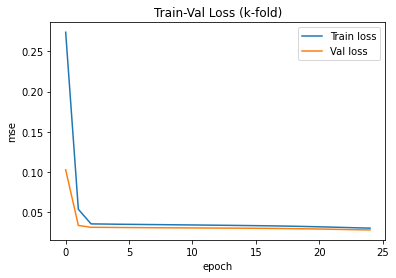

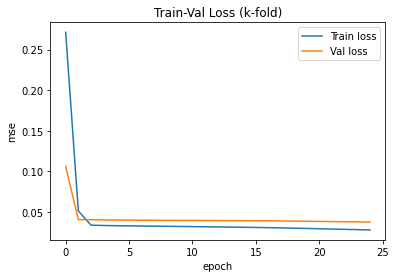

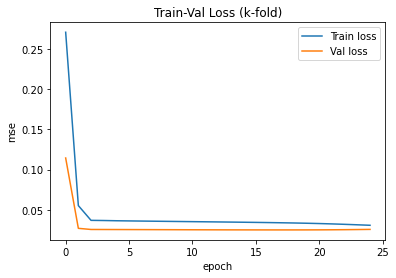

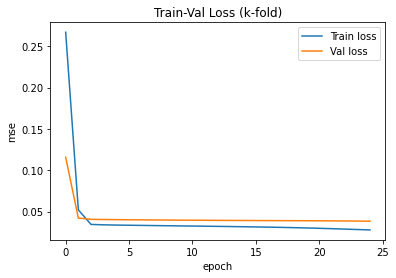

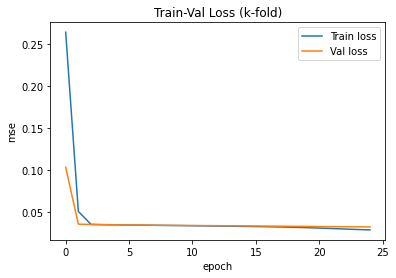

[0.030281462451620472, 0.027922189195773432, 0.030966067575805244, 0.02781502323757325, 0.028345742002995902] [0.02807876104488969, 0.03761182371526957, 0.02586700487881899, 0.03835528623312712, 0.03197289713554912]


In [ ]:
loss_train_cv, loss_val_cv = [], []
for x_train, y_train, x_val, y_val in zip(x_train_cv, y_train_cv, x_val_cv, y_val_cv):
  model, optimizer = model_init()
  model_trained, y_pred_train, loss_train, y_pred_val, loss_val = model_train_val(model, x_train, y_train, x_val, y_val, optimizer, epochs=25)

  loss_train_cv.append(loss_train[-1]), loss_val_cv.append(loss_val[-1])

  plt.plot(loss_train, label = 'Train loss')
  plt.plot(loss_val, label = 'Val loss')
  plt.title(f'Train-Val Loss (k-fold)')
  plt.xlabel('epoch')
  plt.ylabel('mse')
  plt.legend()
  plt.show()
print(loss_train_cv, loss_val_cv)

In [ ]:
# Test GNN
def model_test(model, x_test, y_test):
  model.eval()
  y_pred_test = []
  loss_test = []
  for t in range(len(x_test)-1):
      y_pred = model(G, x_test[t].T) # transpose input shape from (n_features,n_nodes) to (n_nodes,n_features)
      loss = F.mse_loss(y_pred, y_test[t]) # LSTM instead of mean

      y_pred_test.append(y_pred)
      loss_test.append(loss.item())
  return y_pred_test, loss_test

y_pred_test, loss_test = model_test(model_trained, x_test, y_test)

print('Train loss: %.6f, ' %(loss_train_cv[-1]))
print('Validation loss: %.6f, ' %(loss_val_cv[-1]))
print('Test loss: %.6f' %np.mean(loss_test))

Train loss: 0.028346, 
Validation loss: 0.031973, 
Test loss: 0.032671


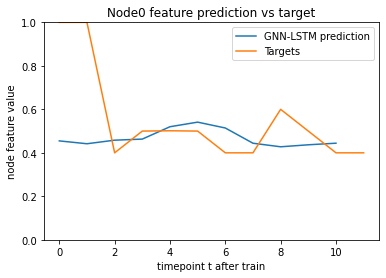

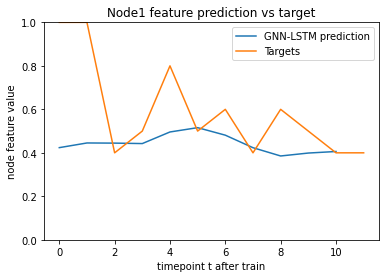

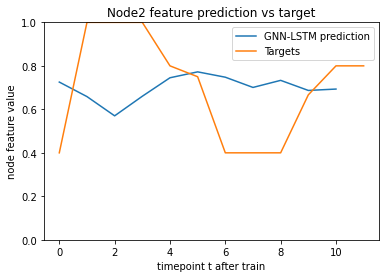

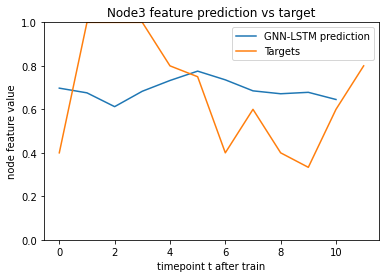

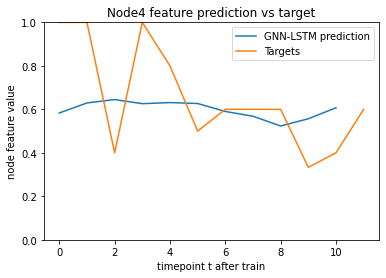

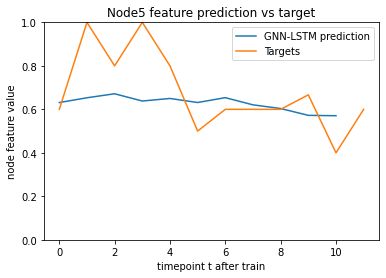

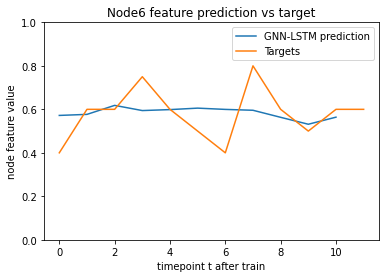

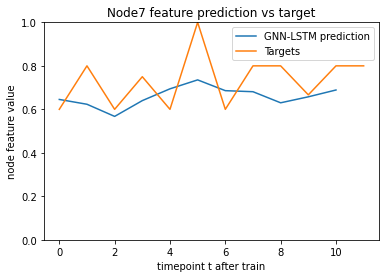

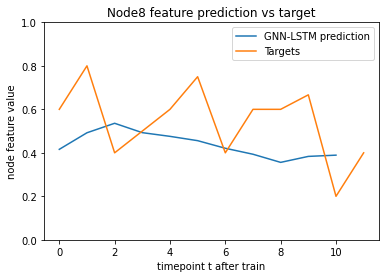

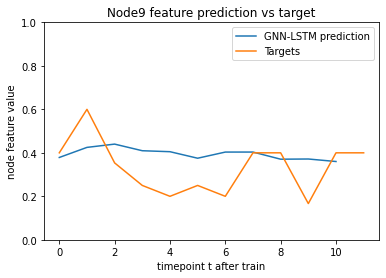

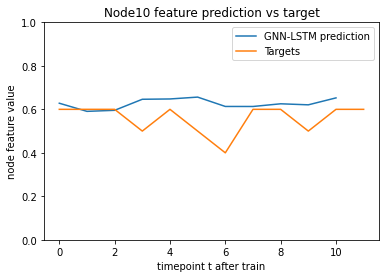

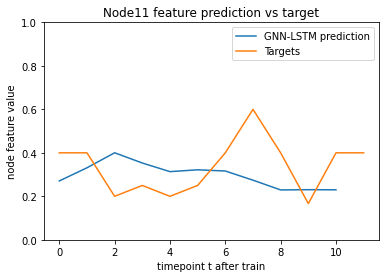

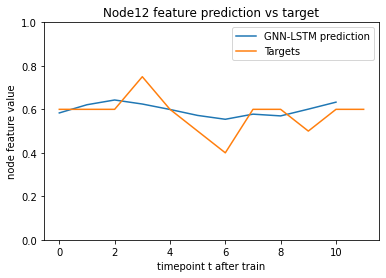

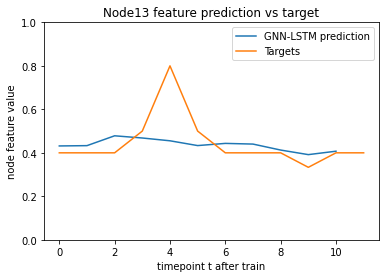

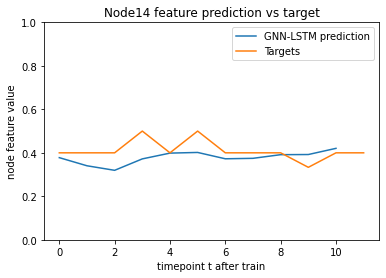

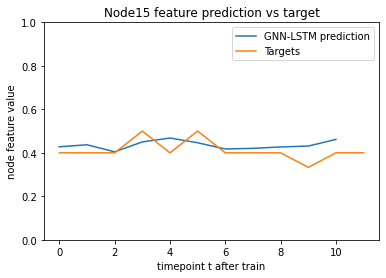

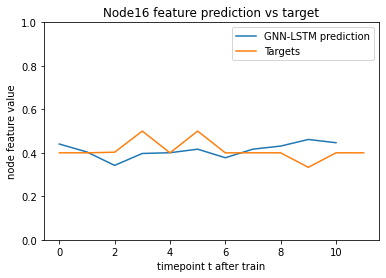

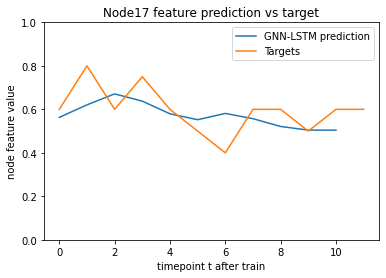

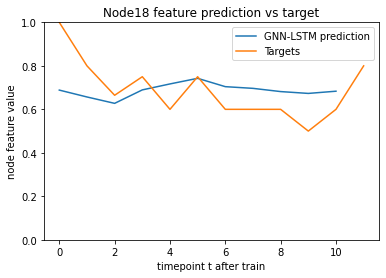

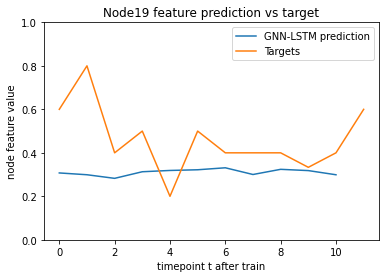

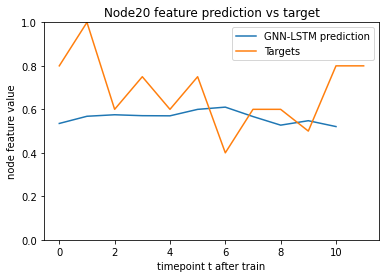

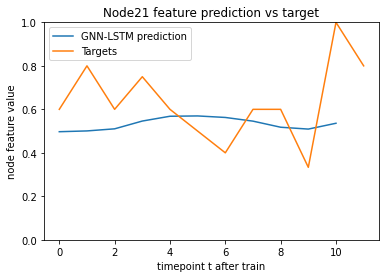

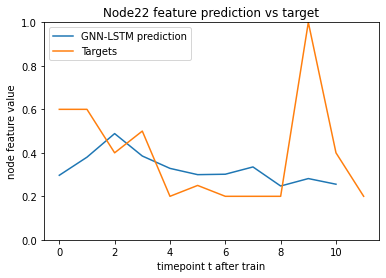

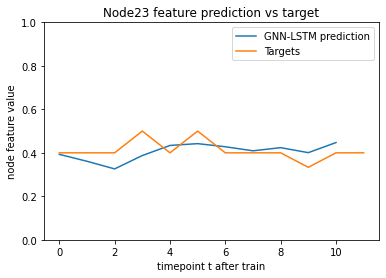

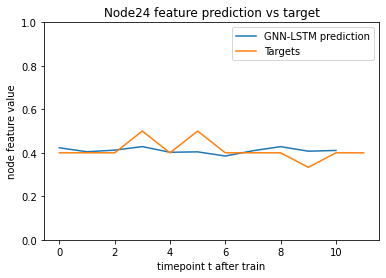

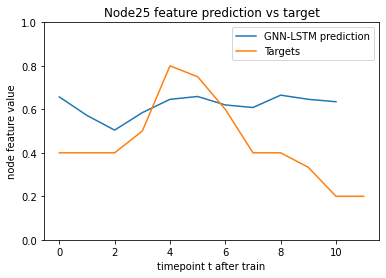

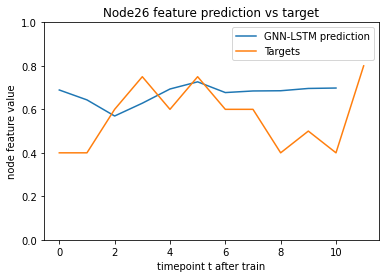

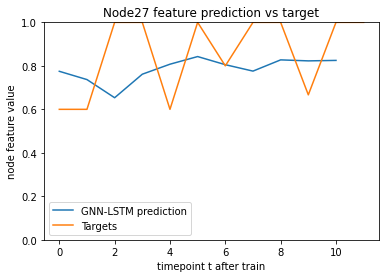

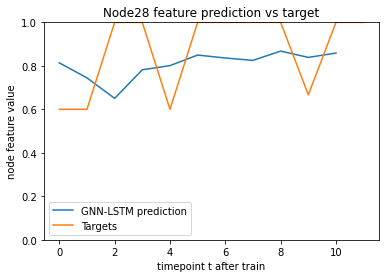

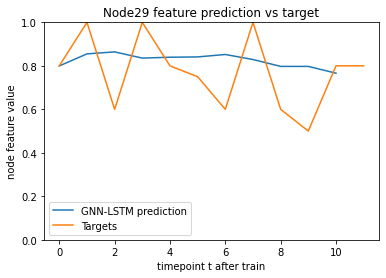

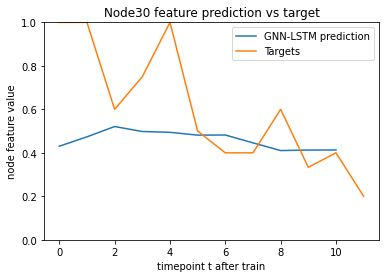

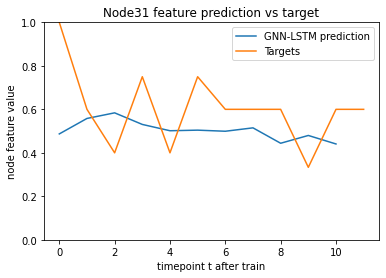

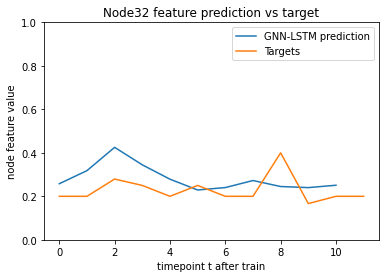

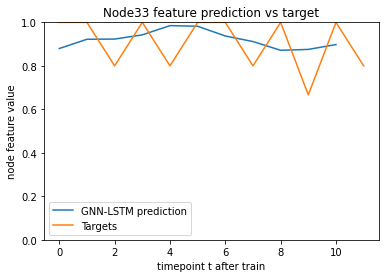

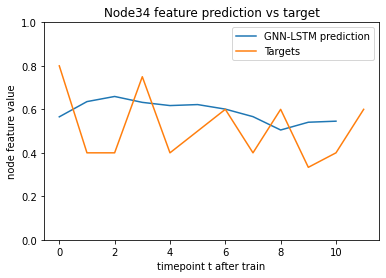

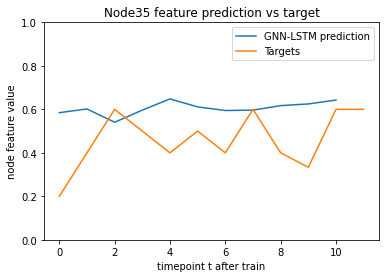

In [ ]:
for node in range(n_nodes):
    plt.plot(th.detach(th.cat(y_pred_test).T[node]).numpy(), label = 'GNN-LSTM prediction')
    plt.plot(y_test.T[node], label = 'Targets')
    plt.title(f'Node{node} feature prediction vs target')
    plt.xlabel('timepoint t after train')
    plt.ylabel('node feature value')
    plt.ylim(0,1)
    plt.legend()
    plt.show()

### **3b. All Patients**

In [ ]:
#playground
n_nodes = 36 # number of nodes in graph
n_features = 3 # number of parallel inputs (i.e. features) = timesteps
n_fold = 5

# Initialize X and Y for train, val, test
X_train_cv, Y_train_cv, X_val_cv, Y_val_cv = [[] for i in range(n_fold)], [[] for i in range(n_fold)], [[] for i in range(n_fold)], [[] for i in range(n_fold)] # create a list of k empty lists for kfold for each dataset
X_test, Y_test = th.tensor([]), th.tensor([])

for df_individual in df_individuals:
    # Initialize train-val data for all individuals
    train, test = preprocess_data(df_individual)
    x_train, y_train = create_inout_sequences(train, n_features) # create LSTM data

    x_train_cv, y_train_cv, x_val_cv, y_val_cv = crossval(x_train, y_train, 'kfold', n_fold) # create cross-validation data
    for fold in range(n_fold):
      X_train_cv[fold].append(x_train_cv[fold]), Y_train_cv[fold].append(y_train_cv[fold]), X_val_cv[fold].append(x_val_cv[fold]), Y_val_cv[fold].append(y_val_cv[fold])

    # Initialize test data for all individuals
    x_test, y_test = create_inout_sequences(test, n_features)
    X_test, Y_test = th.cat((X_test, x_test),0), th.cat((Y_test, y_test),0) # test set

print(len(X_train_cv), len(Y_train_cv), len(X_val_cv), len(Y_val_cv)) # lists in a list, prints out number of folds (=10)
print(len(X_train_cv[0]), len(Y_train_cv[0]), len(X_val_cv[0]), len(Y_val_cv[0])) # tensors in a list, prints out number of patients (=47)
print(X_train_cv[0][0].shape, Y_train_cv[0][0].shape, X_val_cv[0][0].shape, Y_val_cv[0][0].shape) # train data shape for each fold and for each participant, shape = [10 fold, 47 patients, 3D-tensor]
print(X_test.shape, Y_test.shape) # test data shape for each participant

5 5 5 5
47 47 47 47
torch.Size([43, 3, 36]) torch.Size([43, 36]) torch.Size([11, 3, 36]) torch.Size([11, 36])
torch.Size([564, 3, 36]) torch.Size([564, 36])


In [ ]:
# all participants at once

# Train, cross-val, and test
all_loss_train_cv, all_loss_val_cv, all_loss_test_cv = [], [], [] # contains loss train and loss val for all cross-vals
for fold in range(n_fold):
  model, optimizer = model_init(lr=0.0005)
  model_trained, Y_pred_train, all_loss_train, Y_pred_val, all_loss_val = model_train_val(model, th.tensor(np.concatenate(X_train_cv[fold])), th.tensor(np.concatenate(Y_train_cv[fold])), th.tensor(np.concatenate(X_val_cv[fold])), th.tensor(np.concatenate(Y_val_cv[fold])), optimizer, epochs=25) # capital X and Y means for ALL participants
  all_loss_train_cv.append(all_loss_train[-1]), all_loss_val_cv.append(all_loss_val[-1])

  Y_pred_test, all_loss_test = model_test(model_trained, X_test, Y_test)
  all_loss_test_cv.append(np.mean(all_loss_test))

print('Train Loss: %.4f | Val Loss: %.4f | Test Loss: %.4f' % 
      (np.mean(all_loss_train_cv), np.mean(all_loss_val_cv), np.mean(all_loss_test_cv)))

Train Loss: 0.0370 | Val Loss: 0.0512 | Test Loss: 0.0468


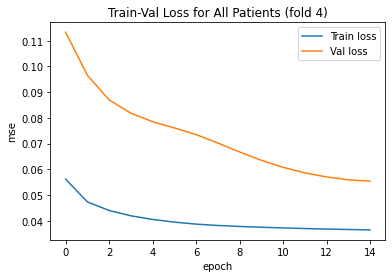

In [ ]:
plt.plot(all_loss_train, label = 'Train loss')
plt.plot(all_loss_val, label = 'Val loss')
plt.title(f'Train-Val Loss for All Patients (fold {fold})')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()
plt.show()

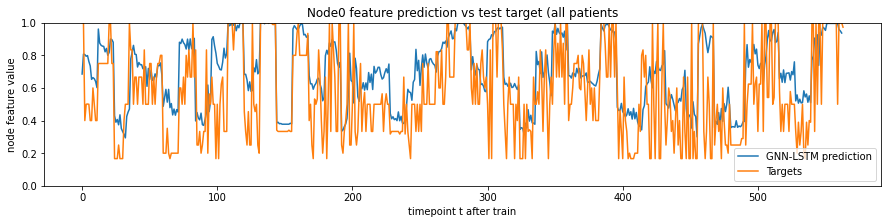

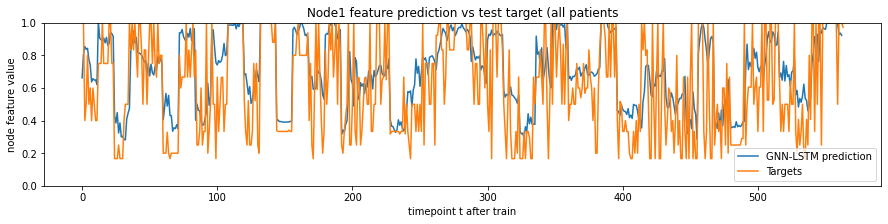

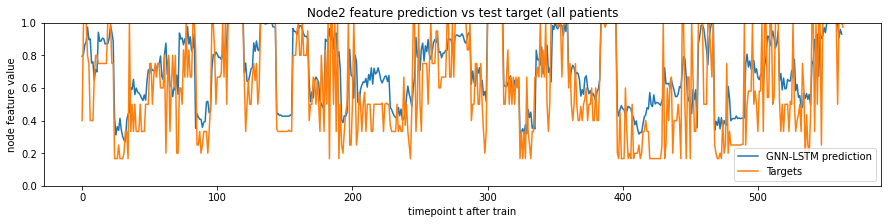

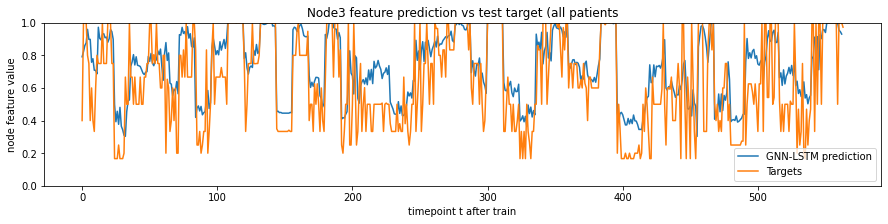

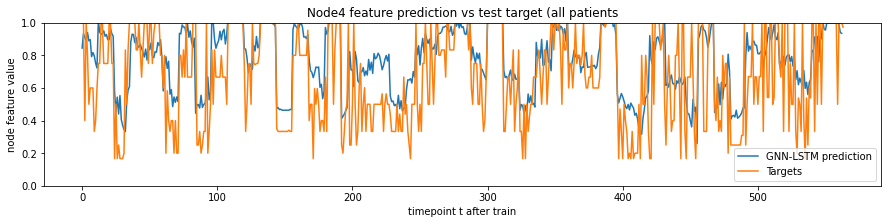

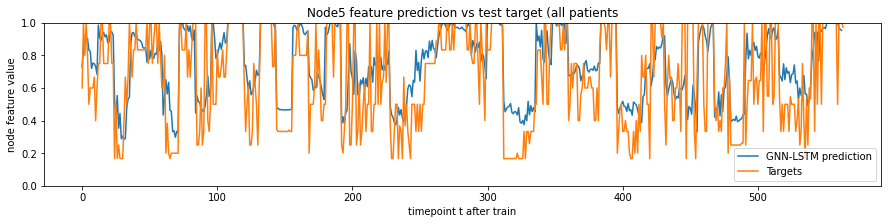

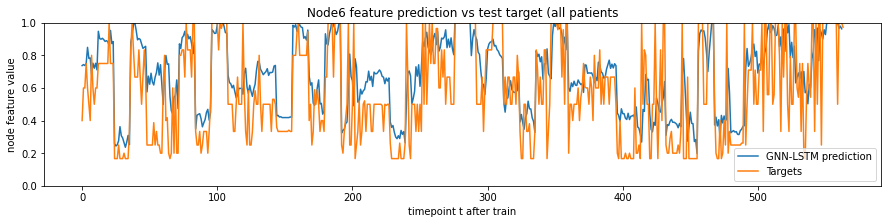

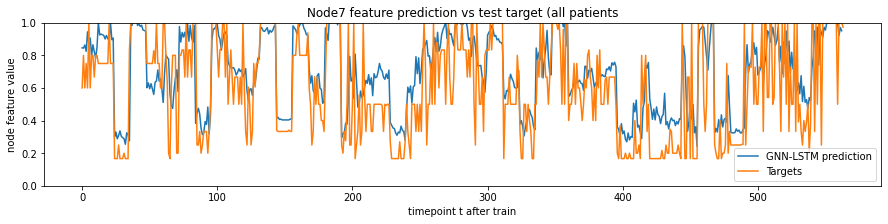

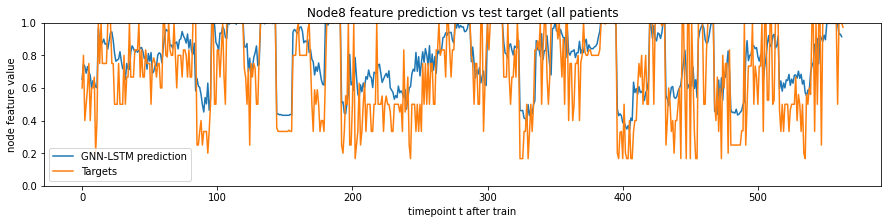

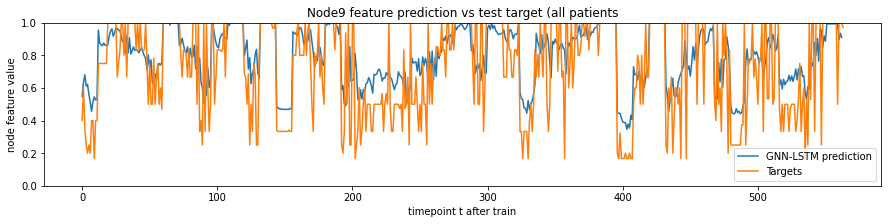

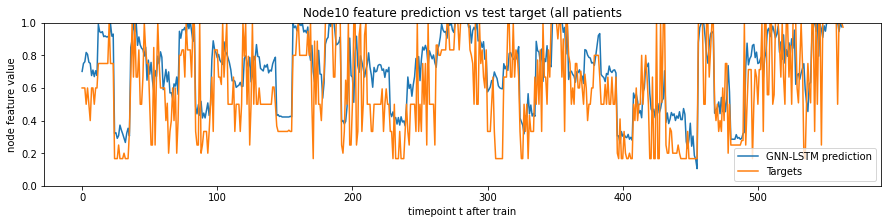

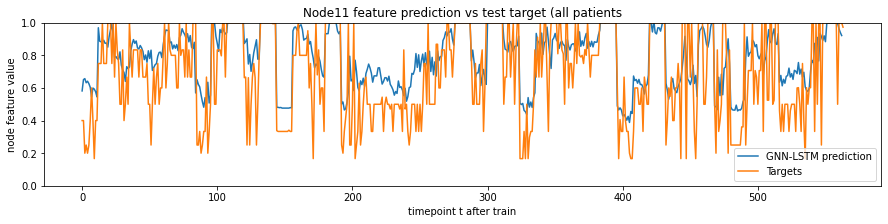

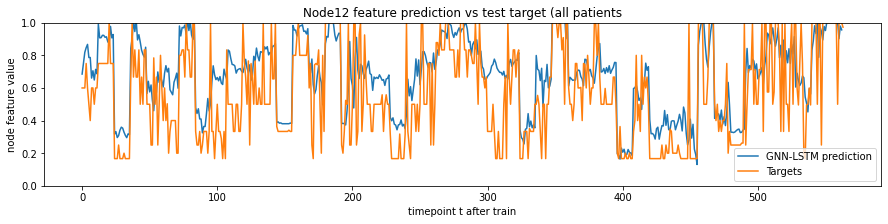

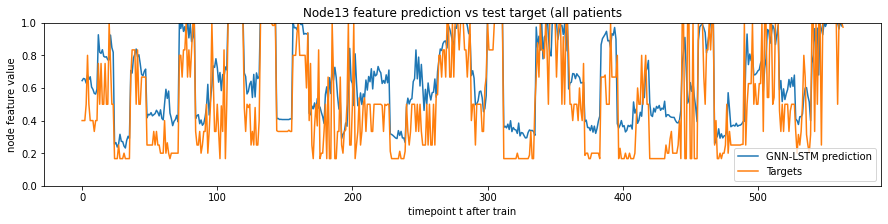

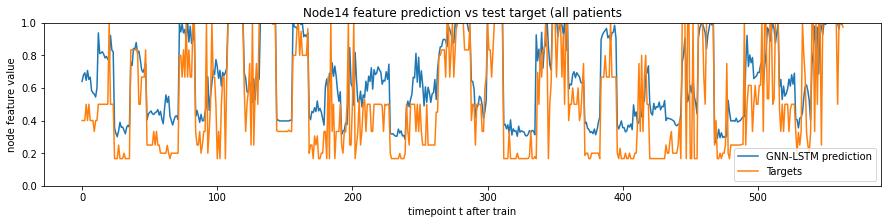

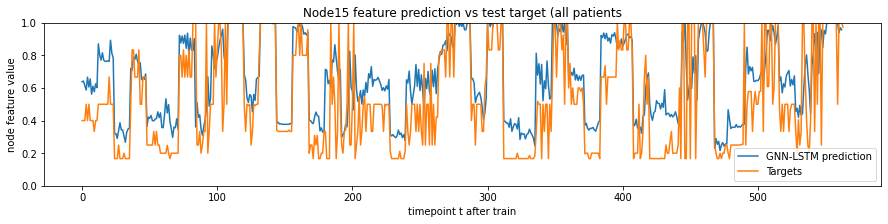

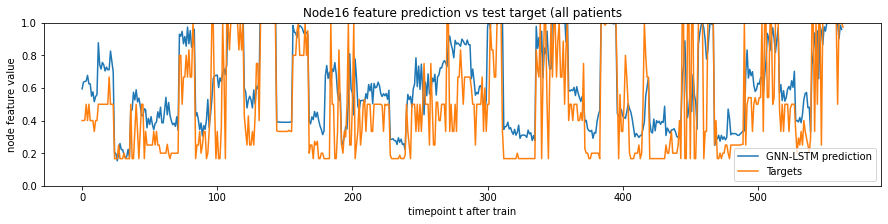

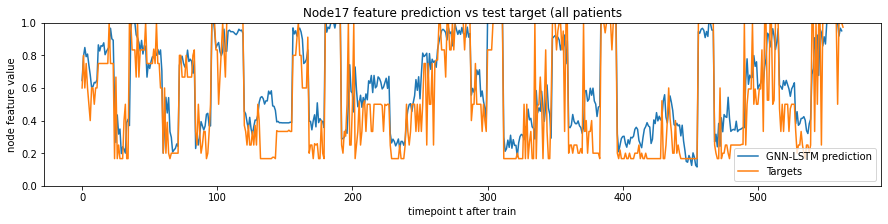

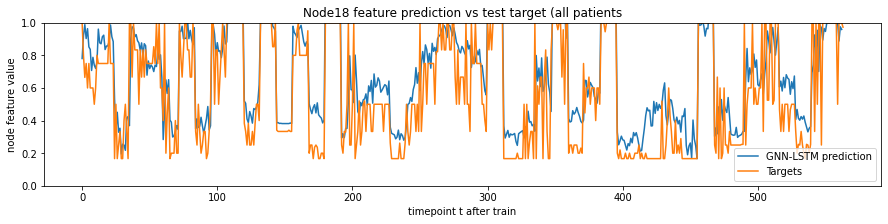

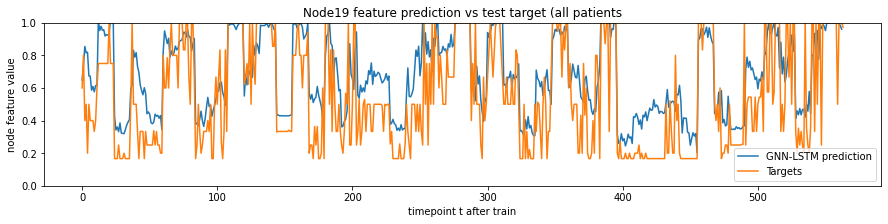

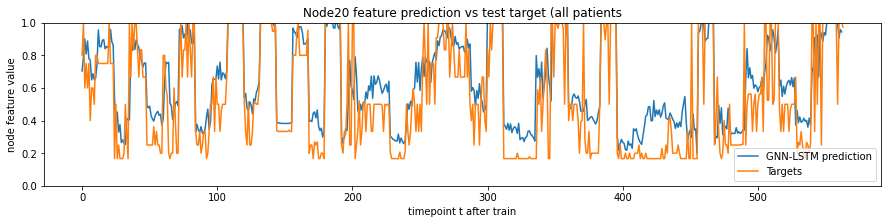

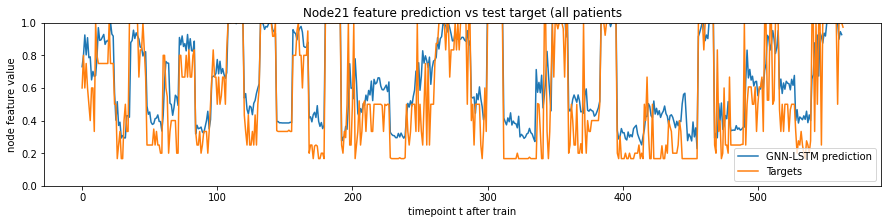

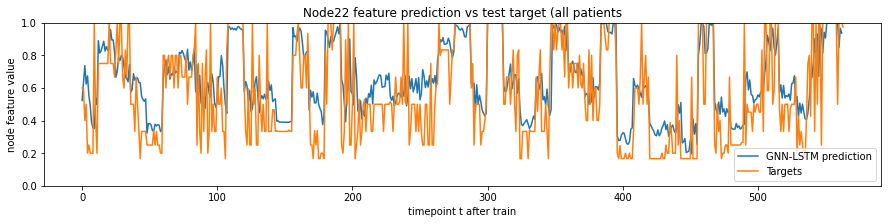

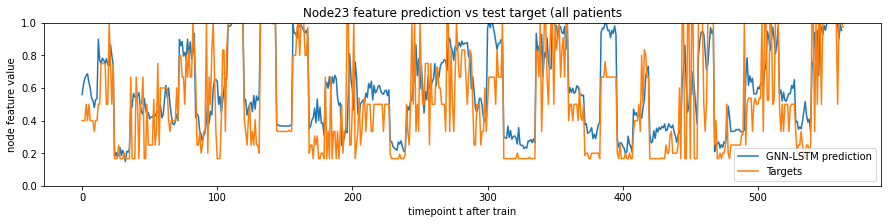

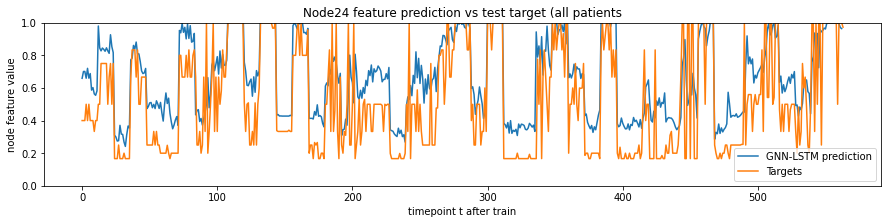

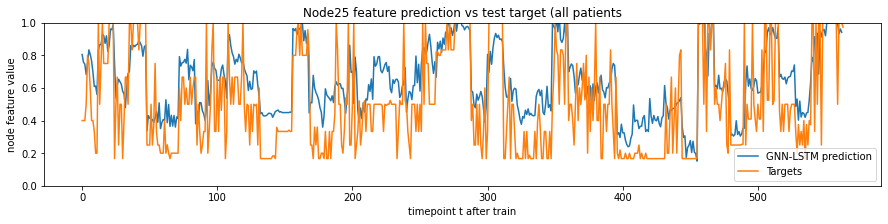

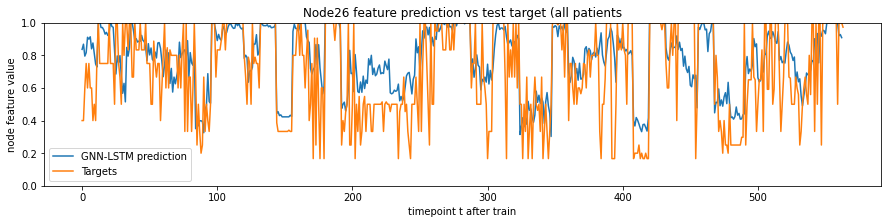

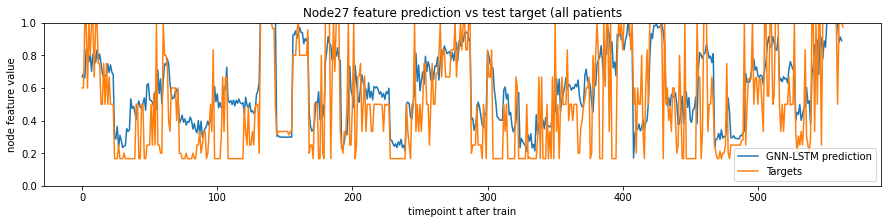

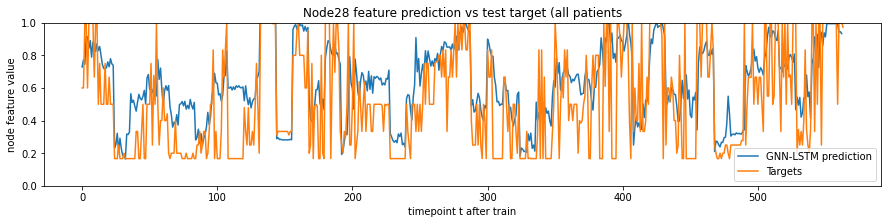

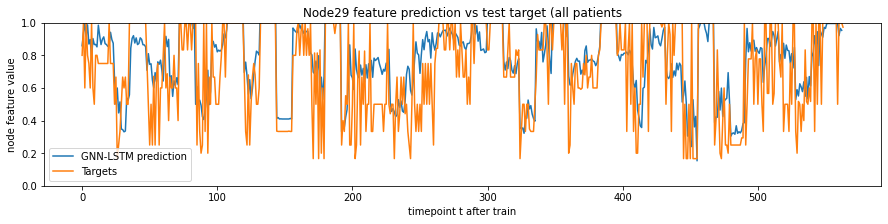

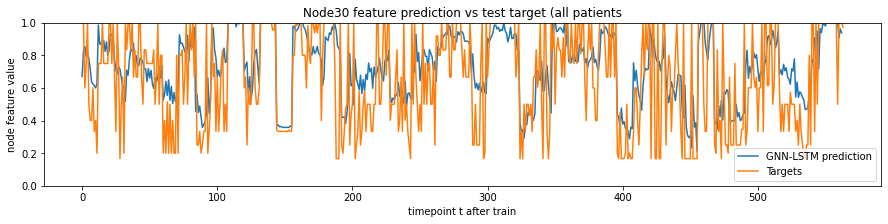

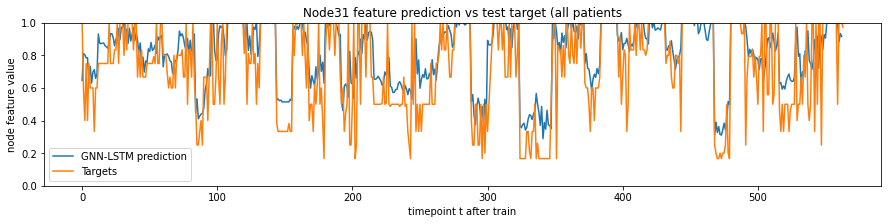

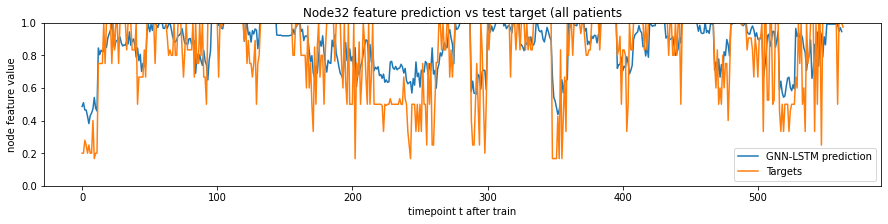

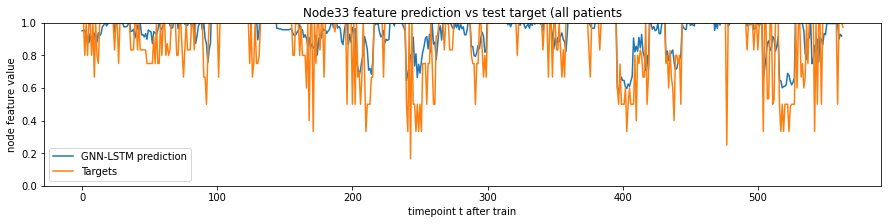

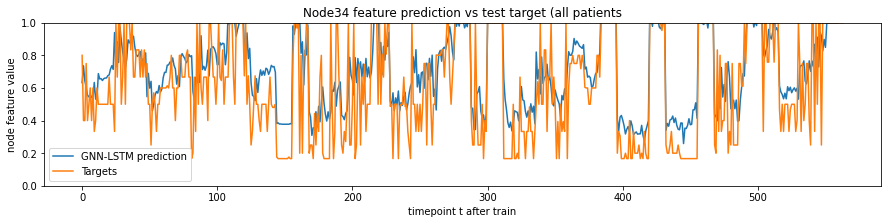

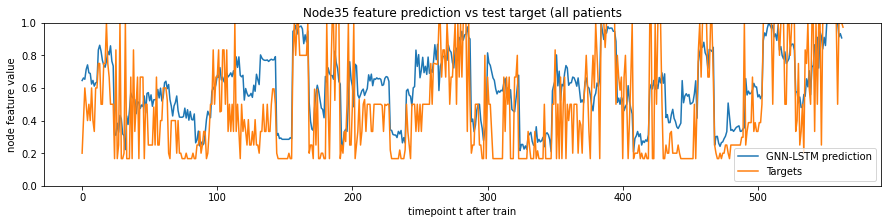

In [ ]:
for node in range(n_nodes):
    plt.figure(figsize=(15,3))
    plt.plot(th.detach(th.cat(Y_pred_test).T[node]).numpy(), label = 'GNN-LSTM prediction')
    plt.plot(Y_test.T[node], label = 'Targets')
    plt.title(f'Node{node} feature prediction vs test target (all patients')
    plt.xlabel('timepoint t after train')
    plt.ylabel('node feature value')
    plt.ylim(0,1)
    plt.legend()
    plt.show()